1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

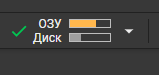



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [1]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

import itertools

2025-05-25 19:33:53.292813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 19:33:53.305162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748201633.319915    4676 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748201633.324208    4676 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-25 19:33:53.338841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Загрузка датасета

грузим и распаковываем архив картинок

In [2]:
# Загрузка датасета из облака

# gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

# !unzip -q 'construction_256x192.zip' # распоковываем архив

In [3]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 192              # Высота картинки
NUM_CLASSES = 5               # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [4]:
train_images = []  # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = []  # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY + "/original")):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(
        image.load_img(
            os.path.join(TRAIN_DIRECTORY + "/original", filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
    )

# Отображаем время загрузки картинок обучающей выборки
print(
    "Обучающая выборка загружена. Время загрузки: ",
    round(time.time() - cur_time, 2),
    "c",
    sep="",
)

# Отображаем количество элементов в обучающей выборке
print("Количество изображений: ", len(train_images))

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY + "/original")):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(
        image.load_img(
            os.path.join(VAL_DIRECTORY + "/original", filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
    )

# Отображаем время загрузки картинок проверочной выборки
print(
    "Проверочная выборка загружена. Время загрузки: ",
    round(time.time() - cur_time, 2),
    "c",
    sep="",
)

# Отображаем количество элементов в проверочной выборке
print("Количество изображений: ", len(val_images))

Обучающая выборка загружена. Время загрузки: 0.18c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [5]:
train_segments = []  # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = []  # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

for filename in sorted(
    os.listdir(TRAIN_DIRECTORY + "/segment")
):  # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(
        image.load_img(
            os.path.join(TRAIN_DIRECTORY + "/segment", filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
    )

# Отображаем время загрузки картинок обучающей выборки
print(
    "Обучающая выборка загружена. Время загрузки: ",
    round(time.time() - cur_time, 2),
    "c",
    sep="",
)

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print("Количество изображений: ", len(train_segments))

cur_time = time.time()  # Засекаем текущее время

for filename in sorted(
    os.listdir(VAL_DIRECTORY + "/segment")
):  # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(
        image.load_img(
            os.path.join(VAL_DIRECTORY + "/segment", filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
    )

# Отображаем время загрузки картинок проверочной выборки
print(
    "Проверочная выборка загружена. Время загрузки: ",
    round(time.time() - cur_time, 2),
    "c",
    sep="",
)

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print("Количество изображений: ", len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.18c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100


## Решение


In [6]:
# Ваше решение
CLASS_LABELS_16 = (
    (100, 100, 100),
    (0, 0, 100),
    (0, 100, 0),
    (100, 0, 0),
    (0, 100, 100),
    (100, 0, 100),
    (100, 100, 0),
    (200, 200, 200),
    (0, 200, 0),
    (200, 0, 0),
    (0, 200, 200),
    (0, 0, 200),
    (200, 0, 200),
    (200, 200, 0),
    (0, 100, 200),
    (100, 0, 200),
)
LABELS_5_CLASS = (0, 1, 2, *[3] * 9, 4, *[3] * 3)
FLOOR = CLASS_LABELS_16[0]
CEILING = CLASS_LABELS_16[1]
WALL = CLASS_LABELS_16[2]
INVENTORY = (200, 0, 200)
OTHER = (100, 0, 0)
CLASS_LABELS_5 = (FLOOR, CEILING, WALL, INVENTORY, OTHER)

In [ ]:
def rgb_to_labels_5(image_list, class_labels=CLASS_LABELS_16, new_labels=CLASS_LABELS_5):
    result = []
    for d in image_list:
        sample = np.array(d)
        y = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype="uint8")

        for i, cl in enumerate(class_labels):


            y[np.where(np.all(sample == class_labels[i], axis=-1))] = new_labels[i]
        result.append(y)
    return np.array(result)


def labels_5_to_rgb(image_list):
    result = []
    for y in image_list:
        temp = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype="uint8")
        for i, cl in enumerate(CLASS_LABELS_5):
            temp[np.where(np.all(y == i, axis=-1))] = CLASS_LABELS_5[i]
        result.append(temp)
    return np.array(result)


In [ ]:
x_train = np.array([image.img_to_array(img) for img in train_images])
x_val = np.array([image.img_to_array(img) for img in val_images])


y_train = rgb_to_labels_5(train_segments, CLASS_LABELS_16, LABELS_5_CLASS)
y_val = rgb_to_labels_5(val_segments, CLASS_LABELS_16, LABELS_5_CLASS)

print("Форма x_train:", x_train.shape)
print("Форма x_val:", x_val.shape)
print("Форма y_train:", y_train.shape)
print("Форма y_val:", y_val.shape)


Форма x_train: (1900, 192, 256, 3)
Форма x_val: (100, 192, 256, 3)
Форма y_train: (1900, 192, 256, 1)
Форма y_val: (100, 192, 256, 1)


In [9]:
def process_images(model, count=1):
    indexes = np.random.randint(0, len(x_val), count)
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)
    orig = labels_5_to_rgb(predict[..., None])

    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    if count == 1:
        axs[0].set_title("Результат работы модели:")
        axs[0].imshow(orig[0])
        axs[0].axis("off")

        axs[1].set_title("Оригинальное сегментированное")
        axs[1].imshow(val_segments[indexes[0]])
        axs[1].axis("off")

        axs[2].set_title("Оригинальное изображение")
        axs[2].imshow(val_images[indexes[0]])
        axs[2].axis("off")
    else:
        for i in range(count):
            axs[0, 0].set_title("Результат работы модели:")
            axs[0, i].imshow(orig[i])
            axs[0, i].axis("off")

            axs[1, 0].set_title("Оригинальное сегментированное")
            axs[1, i].imshow(val_segments[indexes[i]])
            axs[1, i].axis("off")

            axs[2, 0].set_title("Оригинальное изображение")
            axs[2, i].imshow(val_images[indexes[i]])
            axs[2, i].axis("off")
    plt.show()


In [ ]:
def masked_unet(
    CLASS_COUNT, input_shape, filters=64, kernel_size=(3, 3), activation="relu"
):
    img_input = Input(input_shape)

    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_1 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_2 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_3 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_4 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)


    x = Conv2D(filters * 16, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 16, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)


    x = Conv2DTranspose(
        filters * 8, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_4])
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)


    x = Conv2DTranspose(
        filters * 4, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_3])
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)


    x = Conv2DTranspose(
        filters * 2, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_2])
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(
        filters, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_1])
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)


    x = Conv2D(CLASS_COUNT, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)

    model = Model(img_input, x)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


In [ ]:
filters_list = [32, 64]
kernel_size_list = [(3, 3), (7, 7)]
activation_list = ["relu", "linear", "selu"]

experiment_results = []

EPOCHS = 10

In [ ]:
for filters, kernel_size, activation in itertools.product(
    filters_list, kernel_size_list, activation_list
):
    print(
        f"\nЭксперимент с filters={filters}, kernel_size={kernel_size}, activation='{activation}'"
    )

    model_masked_unet = masked_unet(
        NUM_CLASSES,
        (IMG_HEIGHT, IMG_WIDTH, 3),
        filters=filters,
        kernel_size=kernel_size,
        activation=activation,
    )


    history = model_masked_unet.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=16,
        validation_data=(x_val, y_val),
        verbose=1,
    )


    train_accuracy = history.history["sparse_categorical_accuracy"][-1]
    val_accuracy = history.history["val_sparse_categorical_accuracy"][-1]
    del model_masked_unet
    del history

    gc.collect()


    experiment_results.append(
        {
            "filters": filters,
            "kernel_size": kernel_size,
            "activation": activation,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
        }
    )


Эксперимент с filters=32, kernel_size=(3, 3), activation='relu'


I0000 00:00:1748201666.867055    4676 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78670 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:0f:00.0, compute capability: 9.0


Epoch 1/10


I0000 00:00:1748201677.150791    4965 service.cc:148] XLA service 0x7fb6dc001eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748201677.150814    4965 service.cc:156]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-05-25 19:34:37.345468: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1748201677.827307    4965 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1748201678.379590    4965 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-25 19:34:47.269164: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA

  4/119 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.9286 - sparse_categorical_accuracy: 0.2398  

2025-05-25 19:34:51.143308: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads

I0000 00:00:1748201691.198889    4965 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4093 - sparse_categorical_accuracy: 0.4682

W0000 00:00:1748201694.469030    4969 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 1.4073 - sparse_categorical_accuracy: 0.4691

W0000 00:00:1748201706.738695    4965 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1748201708.335826    4965 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - loss: 1.4053 - sparse_categorical_accuracy: 0.4700 - val_loss: 78.1390 - val_sparse_categorical_accuracy: 0.3603
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.8524 - sparse_categorical_accuracy: 0.6977 - val_loss: 2.6209 - val_sparse_categorical_accuracy: 0.5242
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7401 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.4806 - val_sparse_categorical_accuracy: 0.6497
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.7493 - val_loss: 1.4731 - val_sparse_categorical_accuracy: 0.5996
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6598 - sparse_categorical_accuracy: 0.7599 - val_loss: 1.2071 - val_sparse_categorical_accuracy: 0.6013
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6144 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.9552 - val_sparse_categorical_accuracy: 0.6768
Epoch 

W0000 00:00:1748201744.258623    4970 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  4/119 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.0910 - sparse_categorical_accuracy: 0.2215  

2025-05-25 19:35:49.331369: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4067 - sparse_categorical_accuracy: 0.4666

W0000 00:00:1748201752.608335    4970 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4050 - sparse_categorical_accuracy: 0.4674

2025-05-25 19:35:57.427336: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_12', 4 bytes spill stores, 4 bytes spill loads

W0000 00:00:1748201758.178604    4969 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1748201758.866975    4965 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - loss: 1.4033 - sparse_categorical_accuracy: 0.4682 - val_loss: 30.2820 - val_sparse_categorical_accuracy: 0.4495
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.9413 - sparse_categorical_accuracy: 0.6605 - val_loss: 6.9024 - val_sparse_categorical_accuracy: 0.4180
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.8416 - sparse_categorical_accuracy: 0.6918 - val_loss: 3.7587 - val_sparse_categorical_accuracy: 0.4733
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.8222 - sparse_categorical_accuracy: 0.6925 - val_loss: 2.6357 - val_sparse_categorical_accuracy: 0.4586
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7926 - sparse_categorical_accuracy: 0.7047 - val_loss: 1.2669 - val_sparse_categorical_accuracy: 0.6061
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7592 - sparse_categorical_accuracy: 0.7178 - val_loss: 1.7280 - val_sparse_categorical_accuracy: 0.5363
Epoch 7

W0000 00:00:1748201794.880054    4969 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  3/119 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.0515 - sparse_categorical_accuracy: 0.2153  

2025-05-25 19:36:40.626311: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



116/119 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3737 - sparse_categorical_accuracy: 0.4853

W0000 00:00:1748201804.066192    4967 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.3679 - sparse_categorical_accuracy: 0.4879

2025-05-25 19:36:48.789159: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads

W0000 00:00:1748201809.551078    4970 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1748201810.335515    4967 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - loss: 1.3661 - sparse_categorical_accuracy: 0.4888 - val_loss: 24.0223 - val_sparse_categorical_accuracy: 0.3071
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.8635 - sparse_categorical_accuracy: 0.6939 - val_loss: 3.0865 - val_sparse_categorical_accuracy: 0.4062
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7521 - sparse_categorical_accuracy: 0.7264 - val_loss: 1.3839 - val_sparse_categorical_accuracy: 0.5426
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7090 - sparse_categorical_accuracy: 0.7388 - val_loss: 1.5772 - val_sparse_categorical_accuracy: 0.5361
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6724 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.9523 - val_sparse_categorical_accuracy: 0.6526
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6349 - sparse_categorical_accuracy: 0.7642 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.6517
Epoch 7

W0000 00:00:1748201846.384482    4968 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  2/119 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 2.1981 - sparse_categorical_accuracy: 0.2268  

2025-05-25 19:37:47.570529: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.4432 - sparse_categorical_accuracy: 0.4702

W0000 00:00:1748201874.841700    4970 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 1.4415 - sparse_categorical_accuracy: 0.4710

W0000 00:00:1748201893.148244    4969 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1748201894.674148    4969 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 58s 242ms/step - loss: 1.4397 - sparse_categorical_accuracy: 0.4717 - val_loss: 1356.5331 - val_sparse_categorical_accuracy: 0.1692
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.9516 - sparse_categorical_accuracy: 0.6578 - val_loss: 2.7819 - val_sparse_categorical_accuracy: 0.2694
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.8443 - sparse_categorical_accuracy: 0.6976 - val_loss: 2.0084 - val_sparse_categorical_accuracy: 0.5400
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.7748 - sparse_categorical_accuracy: 0.7180 - val_loss: 1.2331 - val_sparse_categorical_accuracy: 0.5128
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.7234 - sparse_categorical_accuracy: 0.7356 - val_loss: 1.1791 - val_sparse_categorical_accuracy: 0.5748
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.7212 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.9726 - val_sparse_categorical_accuracy: 0.6199
Epoc

W0000 00:00:1748201967.610658    4968 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  2/119 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 2.1550 - sparse_categorical_accuracy: 0.1772  

2025-05-25 19:39:33.032969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.5090 - sparse_categorical_accuracy: 0.3924

W0000 00:00:1748201980.249273    4970 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 1.5074 - sparse_categorical_accuracy: 0.3933

2025-05-25 19:39:45.397896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads

W0000 00:00:1748201986.155054    4971 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1748201987.055704    4970 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - loss: 1.5059 - sparse_categorical_accuracy: 0.3943 - val_loss: 557.9153 - val_sparse_categorical_accuracy: 0.1817
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.0299 - sparse_categorical_accuracy: 0.6279 - val_loss: 18.5185 - val_sparse_categorical_accuracy: 0.2370
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.9177 - sparse_categorical_accuracy: 0.6563 - val_loss: 6.2340 - val_sparse_categorical_accuracy: 0.3317
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.8748 - sparse_categorical_accuracy: 0.6678 - val_loss: 5.6468 - val_sparse_categorical_accuracy: 0.3010
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.8640 - sparse_categorical_accuracy: 0.6694 - val_loss: 2.2744 - val_sparse_categorical_accuracy: 0.4997
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.8504 - sparse_categorical_accuracy: 0.6758 - val_loss: 1.7127 - val_sparse_categorical_accuracy: 0.5243
Epoc

2025-05-25 19:41:05.027001: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - loss: 1.4576 - sparse_categorical_accuracy: 0.4408 - val_loss: 768.5447 - val_sparse_categorical_accuracy: 0.2969
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.9568 - sparse_categorical_accuracy: 0.6637 - val_loss: 2.5969 - val_sparse_categorical_accuracy: 0.4860
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.8597 - sparse_categorical_accuracy: 0.6894 - val_loss: 1.8410 - val_sparse_categorical_accuracy: 0.6267
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.7924 - sparse_categorical_accuracy: 0.7104 - val_loss: 2.6594 - val_sparse_categorical_accuracy: 0.2310
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.7745 - sparse_categorical_accuracy: 0.7134 - val_loss: 1.0143 - val_sparse_categorical_accuracy: 0.6361
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.7217 - sparse_categorical_accuracy: 0.7372 - val_loss: 2.3090 - val_sparse_categorical_accuracy: 0.1886
Epoch

2025-05-25 19:42:51.738565: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 56s 236ms/step - loss: 1.3895 - sparse_categorical_accuracy: 0.4939 - val_loss: 2479.0693 - val_sparse_categorical_accuracy: 0.1874
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.8867 - sparse_categorical_accuracy: 0.6684 - val_loss: 4.5078 - val_sparse_categorical_accuracy: 0.5451
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.7864 - sparse_categorical_accuracy: 0.7086 - val_loss: 1.4031 - val_sparse_categorical_accuracy: 0.6194
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.7123 - sparse_categorical_accuracy: 0.7371 - val_loss: 1.5347 - val_sparse_categorical_accuracy: 0.5771
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.6855 - sparse_categorical_accuracy: 0.7480 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.6153
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.6657 - sparse_categorical_accuracy: 0.7580 - val_loss: 1.2185 - val_sparse_categorical_accuracy: 0.5768
Epoc

2025-05-25 19:44:20.204101: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_12', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.5171 - sparse_categorical_accuracy: 0.4071

2025-05-25 19:44:30.724945: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_12', 4 bytes spill stores, 4 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 1.5152 - sparse_categorical_accuracy: 0.4079 - val_loss: 168.5209 - val_sparse_categorical_accuracy: 0.2678
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.9890 - sparse_categorical_accuracy: 0.6343 - val_loss: 11.5184 - val_sparse_categorical_accuracy: 0.3312
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.8623 - sparse_categorical_accuracy: 0.6766 - val_loss: 2.4705 - val_sparse_categorical_accuracy: 0.5360
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.8469 - sparse_categorical_accuracy: 0.6832 - val_loss: 3.0729 - val_sparse_categorical_accuracy: 0.5103
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.8335 - sparse_categorical_accuracy: 0.6853 - val_loss: 2.3461 - val_sparse_categorical_accuracy: 0.4692
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.7982 - sparse_categorical_accuracy: 0.6976 - val_loss: 2.3218 - val_sparse_categorical_accuracy: 0.4833
Epoc

2025-05-25 19:45:35.503729: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.5203 - sparse_categorical_accuracy: 0.4047

2025-05-25 19:45:46.677063: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - loss: 1.5181 - sparse_categorical_accuracy: 0.4057 - val_loss: 522.5378 - val_sparse_categorical_accuracy: 0.0708
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.9055 - sparse_categorical_accuracy: 0.6710 - val_loss: 3.3562 - val_sparse_categorical_accuracy: 0.5568
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.7889 - sparse_categorical_accuracy: 0.7101 - val_loss: 1.6603 - val_sparse_categorical_accuracy: 0.4469
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.7451 - sparse_categorical_accuracy: 0.7277 - val_loss: 1.4637 - val_sparse_categorical_accuracy: 0.5643
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.9691 - val_sparse_categorical_accuracy: 0.6351
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.6521 - sparse_categorical_accuracy: 0.7615 - val_loss: 1.2945 - val_sparse_categorical_accuracy: 0.5395
Epoch

2025-05-25 19:46:48.399771: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,512,25,33]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1024,12,16]{3,2,1,0}, f32[1024,512,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-25 19:46:48.828327: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.428625969s
Trying algorithm eng0{} for conv (f32[16,512,25,33]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1024,12,16]{3,2,1,0}, f32[1024,512,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_co

118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.6093 - sparse_categorical_accuracy: 0.4120

2025-05-25 19:47:57.344438: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[12,512,25,33]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,1024,12,16]{3,2,1,0}, f32[1024,512,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-25 19:47:57.425113: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.080780335s
Trying algorithm eng0{} for conv (f32[12,512,25,33]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,1024,12,16]{3,2,1,0}, f32[1024,512,7,7]{3,2,1,0}), window={size=7x7 stride=2x2 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_co

119/119 ━━━━━━━━━━━━━━━━━━━━ 125s 545ms/step - loss: 1.6046 - sparse_categorical_accuracy: 0.4137 - val_loss: 449.7552 - val_sparse_categorical_accuracy: 0.1688
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - loss: 0.9668 - sparse_categorical_accuracy: 0.6457 - val_loss: 7.1364 - val_sparse_categorical_accuracy: 0.1405
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - loss: 0.8546 - sparse_categorical_accuracy: 0.6835 - val_loss: 4.0421 - val_sparse_categorical_accuracy: 0.1578
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - loss: 0.7966 - sparse_categorical_accuracy: 0.7100 - val_loss: 9.8285 - val_sparse_categorical_accuracy: 0.1795
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - loss: 0.7681 - sparse_categorical_accuracy: 0.7183 - val_loss: 1.1465 - val_sparse_categorical_accuracy: 0.5882
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - loss: 0.7309 - sparse_categorical_accuracy: 0.7304 - val_loss: 2.7811 - val_sparse_categorical_accuracy: 0

2025-05-25 19:51:30.551824: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 1.6979 - sparse_categorical_accuracy: 0.3921

2025-05-25 19:51:52.589251: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 209ms/step - loss: 1.6953 - sparse_categorical_accuracy: 0.3930 - val_loss: 47.7178 - val_sparse_categorical_accuracy: 0.4380
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 1.0733 - sparse_categorical_accuracy: 0.5993 - val_loss: 3.6238 - val_sparse_categorical_accuracy: 0.4755
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.9451 - sparse_categorical_accuracy: 0.6415 - val_loss: 1.7809 - val_sparse_categorical_accuracy: 0.5116
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.8900 - sparse_categorical_accuracy: 0.6616 - val_loss: 1.7697 - val_sparse_categorical_accuracy: 0.5423
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.8860 - sparse_categorical_accuracy: 0.6626 - val_loss: 2.0434 - val_sparse_categorical_accuracy: 0.5667
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.8580 - sparse_categorical_accuracy: 0.6755 - val_loss: 1.5398 - val_sparse_categorical_accuracy: 0.4

2025-05-25 19:54:45.576707: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - loss: 1.8264 - sparse_categorical_accuracy: 0.4164 - val_loss: 58.8885 - val_sparse_categorical_accuracy: 0.3204
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.9820 - sparse_categorical_accuracy: 0.6366 - val_loss: 5.6448 - val_sparse_categorical_accuracy: 0.3133
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.8699 - sparse_categorical_accuracy: 0.6771 - val_loss: 2.6633 - val_sparse_categorical_accuracy: 0.4444
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.8416 - sparse_categorical_accuracy: 0.6890 - val_loss: 1.1708 - val_sparse_categorical_accuracy: 0.6123
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.8052 - sparse_categorical_accuracy: 0.7017 - val_loss: 1.0623 - val_sparse_categorical_accuracy: 0.6128
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - loss: 0.7577 - sparse_categorical_accuracy: 0.7223 - val_loss: 1.3510 - val_sparse_categorical_accuracy: 0.4

In [14]:
import pandas as pd

In [15]:
results_df = pd.DataFrame(experiment_results)
results_df

,filters,kernel_size,activation,train_accuracy,val_accuracy
0,32,"(3, 3)",relu,0.806657,0.689092
1,32,"(3, 3)",linear,0.728444,0.635474
2,32,"(3, 3)",selu,0.800199,0.571713
3,32,"(7, 7)",relu,0.771031,0.544441
4,32,"(7, 7)",linear,0.702281,0.621223
5,32,"(7, 7)",selu,0.761336,0.607680
6,64,"(3, 3)",relu,0.799453,0.419250
7,64,"(3, 3)",linear,0.714001,0.610479
8,64,"(3, 3)",selu,0.790500,0.681658
9,64,"(7, 7)",relu,0.765020,0.565912
